# 성능 최적화 종합실습 : Car seat sales
유아용 카시트 매출액을 예측해 봅시다.

* 카시트에 대해서 지역 매장 별 매출액을 예측하고자 합니다.

![](https://cdn.images.express.co.uk/img/dynamic/24/590x/child-car-seat-986556.jpg?r=1532946857754)

## 1.환경준비

### (1) Import

In [28]:
#라이브러리들을 불러오자.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 전처리
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 모델링
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import * 

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import warnings
warnings.filterwarnings(action='ignore')

### (2) 함수 생성

* 선형회귀용 전진선택법

In [29]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

def forward_stepwise_linear(x_train, y_train):

    # 변수목록, 선택된 변수 목록, 단계별 모델과 AIC 저장소 정의
    features = list(x_train)
    selected = []
    step_df = pd.DataFrame({ 'step':[], 'feature':[],'aic':[]})

    # 
    for s in range(0, len(features)) :
        result =  { 'step':[], 'feature':[],'aic':[]}

        # 변수 목록에서 변수 한개씩 뽑아서 모델에 추가
        for f in features :
            vars = selected + [f]
            x_tr = x_train[vars]
            model = OLS(y_train, add_constant(x_tr)).fit(disp=False) # disp=False 하면 로그 안나옴
            result['step'].append(s+1)
            result['feature'].append(vars)
            result['aic'].append(model.aic)
        
        # 모델별 aic 집계
        temp = pd.DataFrame(result).sort_values('aic').reset_index(drop = True)

        # 만약 이전 aic보다 새로운 aic 가 크다면 멈추기
        if step_df['aic'].min() < temp['aic'].min() :
            break
        step_df = pd.concat([step_df, temp], axis = 0).reset_index(drop = True)

        # 선택된 변수 제거
        v = temp.loc[0,'feature'][s]
        features.remove(v)

        selected.append(v)
    
    # 선택된 변수와 step_df 결과 반환
    return selected, step_df

* 변수 중요도 그래프

In [30]:
def plot_feature_importance(importance, names):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df.reset_index(drop=True, inplace = True)

    plt.figure(figsize=(10,8))
    sns.barplot(x='feature_importance', y='feature_names', data = fi_df)

    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.grid()

    return fi_df

### (3) Data Loading

In [31]:
data_path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/Carseats.csv'
data = pd.read_csv(data_path)

**변수설명**
> * Sales - 각 지역 판매량(단위 : 1000개) <== Target
* CompPrice - 각 지역 경쟁사 가격
* Income - 각 지역 평균 소득수준(단위 : 1000달러)
* Advertising - 각 지역, 회사의 광고 예산(단위 : 1000달러)
* Population - 지역 인구수(단위 : 1000명)
* Price - 자사 지역별 판매가격
* ShelveLoc - 진열상태
* Age - 지역 인구의 평균 연령
* Education - 각 지역 교육수준 레벨
* Urban - 매장 도시 지역 여부
* US - 매장이 미국에 있는지 여부

## 2.데이터 이해

* 둘러보기

In [32]:
data.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


## 3.데이터 준비

### (1) 데이터 정리

In [33]:
data['Diff_Price'] = data['CompPrice'] - data['Price']
data.drop('CompPrice', axis = 1, inplace = True)

### (2) 데이터분할1 : x, y 나누기

In [34]:
target = 'Sales'
x = data.drop(columns=[target], axis=1)

In [35]:
y = data.loc[:, [target]]

### (3) NA 조치

### (4) 가변수화

In [44]:
cols=['ShelveLoc', 'Urban', 'US']
x=pd.get_dummies(data=x, columns=cols, drop_first=True)


KeyError: "None of [Index(['ShelveLoc', 'Urban', 'US'], dtype='object')] are in the [columns]"

In [37]:
x.head()

,Income,Advertising,Population,Price,Age,Education,Diff_Price,ShelveLoc_Good,ShelveLoc_Medium,Urban_Yes,US_Yes
0,73,11,276,120,42,17,18,0,0,1,1
1,48,16,260,83,65,10,28,1,0,1,1
2,35,10,269,80,59,12,33,0,1,1,1
3,100,4,466,97,55,14,20,0,1,1,1
4,64,3,340,128,38,13,13,0,0,1,0


### (5) 데이터분할2 : train : validation 나누기

In [45]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3)

### (6) Scaling
KNN 알고리즘을 적용하기 위해서는 스케일링을 해야 합니다.

In [46]:
scaler = MinMaxScaler()
x_train_s = pd.DataFrame(scaler.fit_transform(x_train), columns=list(x_train))
x_val_s = pd.DataFrame(scaler.transform(x_val), columns=list(x_val))

In [47]:
x_train_s

,Income,Advertising,Population,Price,Age,Education,Diff_Price,ShelveLoc_Good,ShelveLoc_Medium,Urban_Yes,US_Yes
0,0.454545,0.551724,0.625251,0.183824,0.927273,0.625,0.825243,1.0,0.0,1.0,1.0
1,0.717172,0.000000,0.679359,0.713235,0.672727,0.250,0.427184,0.0,1.0,0.0,0.0
2,0.565657,0.517241,0.152305,0.610294,0.418182,1.000,0.330097,0.0,1.0,1.0,1.0
3,0.787879,0.172414,0.577154,0.558824,0.672727,0.250,0.359223,1.0,0.0,1.0,1.0
4,0.838384,0.793103,0.687375,0.588235,0.218182,0.875,0.242718,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
275,0.606061,0.000000,0.362725,0.566176,0.527273,0.750,0.699029,0.0,1.0,1.0,0.0
276,0.545455,0.000000,0.000000,0.522059,0.109091,1.000,0.553398,0.0,0.0,0.0,0.0
277,0.121212,0.241379,0.050100,0.352941,0.636364,0.125,0.786408,0.0,1.0,0.0,1.0
278,0.666667,0.310345,0.444890,0.639706,0.854545,0.000,0.339806,1.0,0.0,1.0,1.0


## 4.모델링



### (1) 선형회귀

In [48]:
model1 = LinearRegression()

In [49]:
model1.fit(x_train, y_train)
pred1=model1.predict(x_val)


In [50]:
print(mean_squared_error(y_val, pred1, squared=False))
print(mean_absolute_error(y_val, pred1))
print(mean_absolute_percentage_error(y_val, pred1))

1.044412979089508
0.791207976320667
0.14469604114655124


### (2) KNN

In [51]:
model2 = KNeighborsRegressor()

In [52]:
params = {
    'n_neighbors': range(1, 50),
    'metric' : ['euclidean', 'manhattan']
}

In [53]:
m_gs = GridSearchCV(model2, params, cv=5, verbose=3)

In [55]:
m_gs.fit(x_train_s, y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': range(1, 50)})

In [56]:
m_gs.best_params_

{'metric': 'manhattan', 'n_neighbors': 6}

In [57]:
m_gs.best_estimator_

KNeighborsRegressor(metric='manhattan', n_neighbors=6)

In [58]:
m_gs.best_score_

0.5135034694481451

In [65]:
pred2 = m_gs.predict(x_val_s)

In [66]:
print(mean_squared_error(y_val, pred2))
print(mean_absolute_error(y_val, pred2))
print(mean_absolute_percentage_error(y_val, pred2))

2.808974675925926
1.3350833333333334
0.30348103873010096


In [95]:
results = pd.DataFrame(m_gs.cv_results_)

In [96]:
tmp = results.loc[:, ['param_n_neighbors', 'mean_test_score', 'param_metric']]

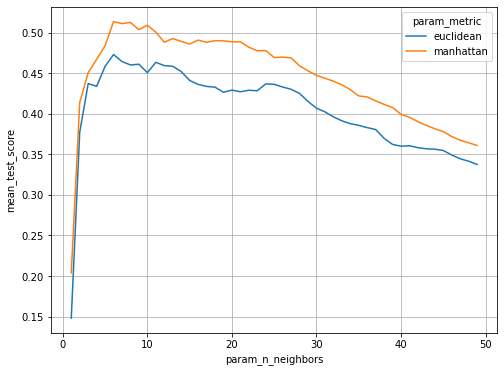

In [99]:
plt.figure(figsize=(8, 6))
sns.lineplot(x = 'param_n_neighbors', y='mean_test_score', data=tmp, hue='param_metric')
plt.grid()
plt.show()

### (3) Decision Tree

In [67]:
model3 = DecisionTreeRegressor()

In [68]:
params = {
    'max_depth': [3, 5, 8],
    'min_samples_leaf': range(1, 201, 50)
}

In [69]:
m_gs2 = GridSearchCV(model3, params, cv=5, verbose=3)

In [70]:
m_gs2.fit(x_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END ................max_depth=3, min_samples_leaf=1; total time=   0.0s
[CV 2/5] END ................max_depth=3, min_samples_leaf=1; total time=   0.0s
[CV 3/5] END ................max_depth=3, min_samples_leaf=1; total time=   0.0s
[CV 4/5] END ................max_depth=3, min_samples_leaf=1; total time=   0.0s
[CV 5/5] END ................max_depth=3, min_samples_leaf=1; total time=   0.0s
[CV 1/5] END ...............max_depth=3, min_samples_leaf=51; total time=   0.0s
[CV 2/5] END ...............max_depth=3, min_samples_leaf=51; total time=   0.0s
[CV 3/5] END ...............max_depth=3, min_samples_leaf=51; total time=   0.0s
[CV 4/5] END ...............max_depth=3, min_samples_leaf=51; total time=   0.0s
[CV 5/5] END ...............max_depth=3, min_samples_leaf=51; total time=   0.0s
[CV 1/5] END ..............max_depth=3, min_samples_leaf=101; total time=   0.0s
[CV 2/5] END ..............max_depth=3, min_samp

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [3, 5, 8],
                         'min_samples_leaf': range(1, 201, 50)},
             verbose=3)

In [71]:
m_gs2.best_estimator_

DecisionTreeRegressor(max_depth=8)

In [103]:
results2 = pd.DataFrame(m_gs2.cv_results_)
tmp2 = results2.loc[:, ['param_max_depth', 'mean_test_score', 'param_min_samples_leaf']]

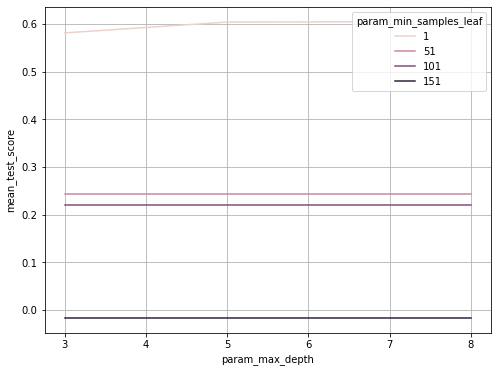

In [104]:
plt.figure(figsize=(8, 6))
sns.lineplot(x = 'param_max_depth', y='mean_test_score', data=tmp2, hue='param_min_samples_leaf')
plt.grid()
plt.show()

,feature_names,feature_importance
0,Diff_Price,0.436799
1,ShelveLoc_Good,0.285649
2,Advertising,0.101479
3,Age,0.047410
4,Income,0.033089
5,Population,0.032598
6,Price,0.023293
7,ShelveLoc_Medium,0.019679
8,Urban_Yes,0.010903
9,Education,0.005870


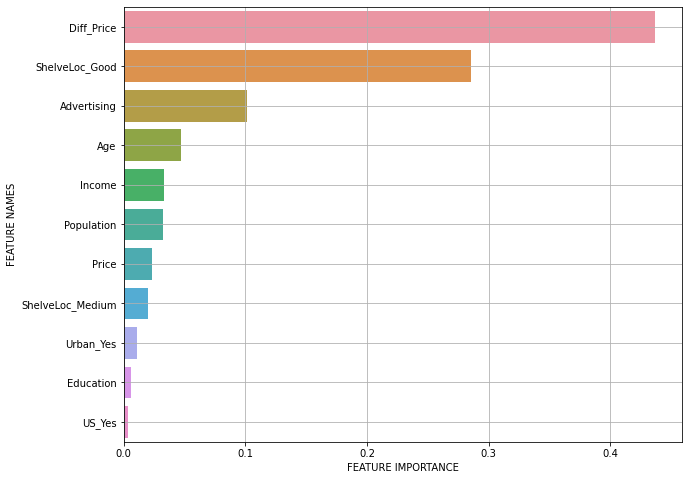

In [72]:
plot_feature_importance(m_gs2.best_estimator_.feature_importances_, x_train_s.columns)

### (4) Random Forest

In [73]:
model4 = RandomForestRegressor()

In [75]:

x_train.shape

(280, 11)

In [76]:
params = {
    'n_estimators': [50, 100, 150],
    'max_features': range(1, 12),
    'max_depth':[3, 5, 8]
    
}

In [77]:
m_gs4 = GridSearchCV(model4, params, cv=5, verbose=3)

In [78]:
m_gs4.fit(x_train, y_train)

Fitting 5 folds for each of 99 candidates, totalling 495 fits
[CV 1/5] END ...max_depth=3, max_features=1, n_estimators=50; total time=   0.0s
[CV 2/5] END ...max_depth=3, max_features=1, n_estimators=50; total time=   0.0s
[CV 3/5] END ...max_depth=3, max_features=1, n_estimators=50; total time=   0.0s
[CV 4/5] END ...max_depth=3, max_features=1, n_estimators=50; total time=   0.0s
[CV 5/5] END ...max_depth=3, max_features=1, n_estimators=50; total time=   0.0s
[CV 1/5] END ..max_depth=3, max_features=1, n_estimators=100; total time=   0.1s
[CV 2/5] END ..max_depth=3, max_features=1, n_estimators=100; total time=   0.0s
[CV 3/5] END ..max_depth=3, max_features=1, n_estimators=100; total time=   0.1s
[CV 4/5] END ..max_depth=3, max_features=1, n_estimators=100; total time=   0.0s
[CV 5/5] END ..max_depth=3, max_features=1, n_estimators=100; total time=   0.1s
[CV 1/5] END ..max_depth=3, max_features=1, n_estimators=150; total time=   0.2s
[CV 2/5] END ..max_depth=3, max_features=1, n_e

[CV 2/5] END ..max_depth=3, max_features=7, n_estimators=150; total time=   0.1s
[CV 3/5] END ..max_depth=3, max_features=7, n_estimators=150; total time=   0.1s
[CV 4/5] END ..max_depth=3, max_features=7, n_estimators=150; total time=   0.2s
[CV 5/5] END ..max_depth=3, max_features=7, n_estimators=150; total time=   0.2s
[CV 1/5] END ...max_depth=3, max_features=8, n_estimators=50; total time=   0.0s
[CV 2/5] END ...max_depth=3, max_features=8, n_estimators=50; total time=   0.0s
[CV 3/5] END ...max_depth=3, max_features=8, n_estimators=50; total time=   0.0s
[CV 4/5] END ...max_depth=3, max_features=8, n_estimators=50; total time=   0.0s
[CV 5/5] END ...max_depth=3, max_features=8, n_estimators=50; total time=   0.0s
[CV 1/5] END ..max_depth=3, max_features=8, n_estimators=100; total time=   0.1s
[CV 2/5] END ..max_depth=3, max_features=8, n_estimators=100; total time=   0.1s
[CV 3/5] END ..max_depth=3, max_features=8, n_estimators=100; total time=   0.1s
[CV 4/5] END ..max_depth=3, 

[CV 5/5] END ..max_depth=5, max_features=3, n_estimators=100; total time=   0.0s
[CV 1/5] END ..max_depth=5, max_features=3, n_estimators=150; total time=   0.1s
[CV 2/5] END ..max_depth=5, max_features=3, n_estimators=150; total time=   0.1s
[CV 3/5] END ..max_depth=5, max_features=3, n_estimators=150; total time=   0.1s
[CV 4/5] END ..max_depth=5, max_features=3, n_estimators=150; total time=   0.1s
[CV 5/5] END ..max_depth=5, max_features=3, n_estimators=150; total time=   0.1s
[CV 1/5] END ...max_depth=5, max_features=4, n_estimators=50; total time=   0.0s
[CV 2/5] END ...max_depth=5, max_features=4, n_estimators=50; total time=   0.0s
[CV 3/5] END ...max_depth=5, max_features=4, n_estimators=50; total time=   0.0s
[CV 4/5] END ...max_depth=5, max_features=4, n_estimators=50; total time=   0.0s
[CV 5/5] END ...max_depth=5, max_features=4, n_estimators=50; total time=   0.0s
[CV 1/5] END ..max_depth=5, max_features=4, n_estimators=100; total time=   0.1s
[CV 2/5] END ..max_depth=5, 

[CV 2/5] END .max_depth=5, max_features=10, n_estimators=100; total time=   0.1s
[CV 3/5] END .max_depth=5, max_features=10, n_estimators=100; total time=   0.1s
[CV 4/5] END .max_depth=5, max_features=10, n_estimators=100; total time=   0.1s
[CV 5/5] END .max_depth=5, max_features=10, n_estimators=100; total time=   0.1s
[CV 1/5] END .max_depth=5, max_features=10, n_estimators=150; total time=   0.2s
[CV 2/5] END .max_depth=5, max_features=10, n_estimators=150; total time=   0.3s
[CV 3/5] END .max_depth=5, max_features=10, n_estimators=150; total time=   0.2s
[CV 4/5] END .max_depth=5, max_features=10, n_estimators=150; total time=   0.2s
[CV 5/5] END .max_depth=5, max_features=10, n_estimators=150; total time=   0.2s
[CV 1/5] END ..max_depth=5, max_features=11, n_estimators=50; total time=   0.0s
[CV 2/5] END ..max_depth=5, max_features=11, n_estimators=50; total time=   0.0s
[CV 3/5] END ..max_depth=5, max_features=11, n_estimators=50; total time=   0.0s
[CV 4/5] END ..max_depth=5, 

[CV 1/5] END ..max_depth=8, max_features=6, n_estimators=100; total time=   0.1s
[CV 2/5] END ..max_depth=8, max_features=6, n_estimators=100; total time=   0.1s
[CV 3/5] END ..max_depth=8, max_features=6, n_estimators=100; total time=   0.1s
[CV 4/5] END ..max_depth=8, max_features=6, n_estimators=100; total time=   0.1s
[CV 5/5] END ..max_depth=8, max_features=6, n_estimators=100; total time=   0.2s
[CV 1/5] END ..max_depth=8, max_features=6, n_estimators=150; total time=   0.2s
[CV 2/5] END ..max_depth=8, max_features=6, n_estimators=150; total time=   0.2s
[CV 3/5] END ..max_depth=8, max_features=6, n_estimators=150; total time=   0.2s
[CV 4/5] END ..max_depth=8, max_features=6, n_estimators=150; total time=   0.2s
[CV 5/5] END ..max_depth=8, max_features=6, n_estimators=150; total time=   0.2s
[CV 1/5] END ...max_depth=8, max_features=7, n_estimators=50; total time=   0.0s
[CV 2/5] END ...max_depth=8, max_features=7, n_estimators=50; total time=   0.0s
[CV 3/5] END ...max_depth=8,

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [3, 5, 8], 'max_features': range(1, 12),
                         'n_estimators': [50, 100, 150]},
             verbose=3)

,feature_names,feature_importance
0,Diff_Price,0.444810
1,ShelveLoc_Good,0.238449
2,Advertising,0.111465
3,Age,0.058030
4,Income,0.037797
5,Population,0.031723
6,Price,0.031082
7,ShelveLoc_Medium,0.025595
8,Education,0.014971
9,Urban_Yes,0.003368


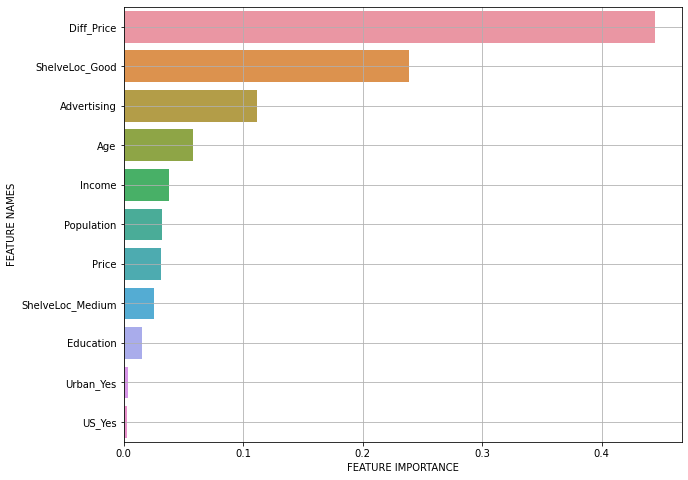

In [80]:
plot_feature_importance(m_gs4.best_estimator_.feature_importances_, x_train.columns)

### (5) XGB

In [81]:
model5 = XGBRegressor()

In [82]:
params = {
    'max_depth' : [3, 5, 8],
    'n_estimators' : [50, 100, 150],
    'learning_rate' : np.linspace(0.1, 0.2, 3)
}

# learning_rate은 오차를 반영하는 비율, 
# learning_rate을 낮추면 보폭을 작게

# n_estimators는 얼마나 많이?
# n_estimators를 늘리면 많이 움직이는 것

In [83]:
m_gs5 = GridSearchCV(model5, params, cv=5, verbose=3)

In [84]:
m_gs5.fit(x_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=50; total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=50; total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=50; total time=   0.0s
[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=50; total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=50; total time=   0.0s
[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.0s
[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.0s
[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=150; total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth

[CV 2/5] END learning_rate=0.2, max_depth=3, n_estimators=50; total time=   0.0s
[CV 3/5] END learning_rate=0.2, max_depth=3, n_estimators=50; total time=   0.0s
[CV 4/5] END learning_rate=0.2, max_depth=3, n_estimators=50; total time=   0.0s
[CV 5/5] END learning_rate=0.2, max_depth=3, n_estimators=50; total time=   0.0s
[CV 1/5] END learning_rate=0.2, max_depth=3, n_estimators=100; total time=   0.0s
[CV 2/5] END learning_rate=0.2, max_depth=3, n_estimators=100; total time=   0.0s
[CV 3/5] END learning_rate=0.2, max_depth=3, n_estimators=100; total time=   0.0s
[CV 4/5] END learning_rate=0.2, max_depth=3, n_estimators=100; total time=   0.0s
[CV 5/5] END learning_rate=0.2, max_depth=3, n_estimators=100; total time=   0.0s
[CV 1/5] END learning_rate=0.2, max_depth=3, n_estimators=150; total time=   0.0s
[CV 2/5] END learning_rate=0.2, max_depth=3, n_estimators=150; total time=   0.0s
[CV 3/5] END learning_rate=0.2, max_depth=3, n_estimators=150; total time=   0.0s
[CV 4/5] END learnin

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...hot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
    

In [85]:
m_gs5.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [88]:
pred5 = m_gs5.predict(x_val)
print(mean_squared_error(y_val, pred5, squared=False))
print(mean_absolute_error(y_val, pred5))
print(mean_absolute_percentage_error(y_val, pred5))

1.1700504935293494
0.8934481445948284
0.18834270760997515


,feature_names,feature_importance
0,ShelveLoc_Good,0.402432
1,Diff_Price,0.219799
2,ShelveLoc_Medium,0.115079
3,Advertising,0.101255
4,Age,0.056961
5,US_Yes,0.026328
6,Income,0.024021
7,Urban_Yes,0.014693
8,Population,0.014218
9,Price,0.012709


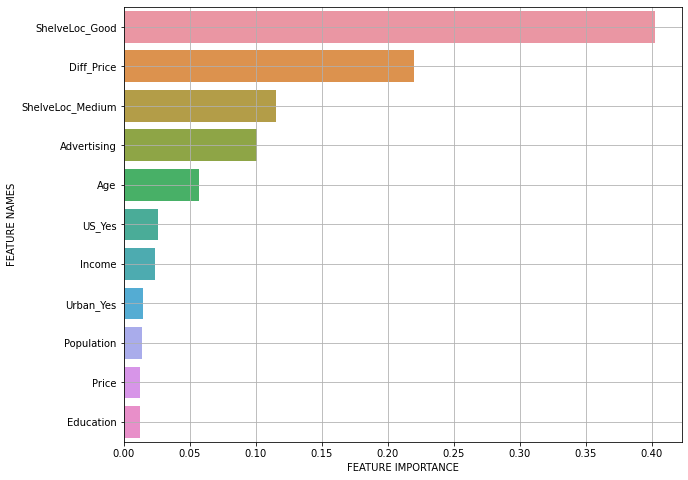

In [86]:
plot_feature_importance(m_gs5.best_estimator_.feature_importances_, x_train.columns)

In [89]:
m_gs5.cv_results_

{'mean_fit_time': array([0.04701228, 0.07484665, 0.11094327, 0.05445437, 0.0960072 ,
        0.13425908, 0.08025379, 0.11460013, 0.18310628, 0.05813518,
        0.09063239, 0.1141171 , 0.05022793, 0.09362392, 0.13213592,
        0.05836272, 0.13299012, 0.1489779 , 0.04427814, 0.08870173,
        0.12243314, 0.05270972, 0.09334817, 0.12637539, 0.06331844,
        0.10759854, 0.16380672]),
 'std_fit_time': array([0.00626262, 0.0025874 , 0.00161077, 0.00258997, 0.00456117,
        0.00464413, 0.00933264, 0.0052141 , 0.02627928, 0.00786978,
        0.01317132, 0.00867828, 0.00301556, 0.00332313, 0.00364132,
        0.00131823, 0.01359839, 0.00233768, 0.00248954, 0.01008564,
        0.01244055, 0.00374622, 0.00302013, 0.00267632, 0.00413384,
        0.00376787, 0.00728034]),
 'mean_score_time': array([0.0065958 , 0.00694938, 0.00740356, 0.00687027, 0.00735607,
        0.00741019, 0.0088016 , 0.00820804, 0.00827198, 0.00835319,
        0.00917397, 0.00787096, 0.00677681, 0.00707016, 0.007085

In [90]:
result = pd.DataFrame(m_gs5.cv_results_)

In [91]:
result.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.047012,0.006263,0.006596,0.000479,0.1,3,50,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.792594,0.740113,0.826116,0.733597,0.798364,0.778157,0.035636,5
1,0.074847,0.002587,0.006949,0.000947,0.1,3,100,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.776554,0.766176,0.833363,0.749468,0.816373,0.788387,0.031477,1
2,0.110943,0.001611,0.007404,0.000829,0.1,3,150,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.764173,0.760873,0.821923,0.739998,0.816638,0.780721,0.032600,4
3,0.054454,0.002590,0.006870,0.000475,0.1,5,50,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.766894,0.728664,0.810135,0.738802,0.780681,0.765035,0.029303,9
4,0.096007,0.004561,0.007356,0.001037,0.1,5,100,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.755332,0.734736,0.814296,0.734362,0.780930,0.763931,0.030418,10


In [92]:
temp = result.loc[:, ['param_n_estimators', 'mean_test_score']]

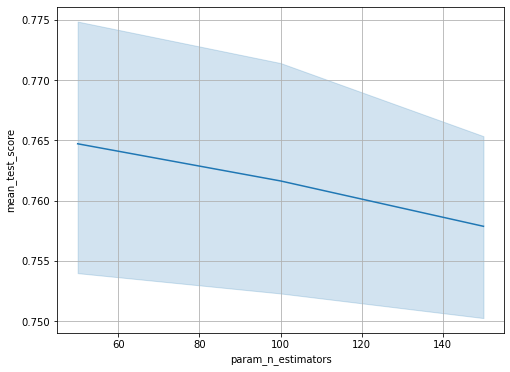

In [93]:
plt.figure(figsize = (8,6))
sns.lineplot(x = 'param_n_estimators', y = 'mean_test_score', data = temp )
plt.grid()
plt.show()

### (6) SVM

In [106]:
params = {
    'C' : np.linspace(0.01, 100, 50),
    'gamma': [0.001, 0.01, 0.1, 1]
}

In [107]:
from sklearn.svm import SVR
model6 = SVR()

In [108]:
m_gs6 = GridSearchCV(model6, params, cv=5, verbose=3)

In [110]:
m_gs6.fit(x_train_s, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV 1/5] END ............................C=0.01, gamma=0.001; total time=   0.0s
[CV 2/5] END ............................C=0.01, gamma=0.001; total time=   0.0s
[CV 3/5] END ............................C=0.01, gamma=0.001; total time=   0.0s
[CV 4/5] END ............................C=0.01, gamma=0.001; total time=   0.0s
[CV 5/5] END ............................C=0.01, gamma=0.001; total time=   0.0s
[CV 1/5] END .............................C=0.01, gamma=0.01; total time=   0.0s
[CV 2/5] END .............................C=0.01, gamma=0.01; total time=   0.0s
[CV 3/5] END .............................C=0.01, gamma=0.01; total time=   0.0s
[CV 4/5] END .............................C=0.01, gamma=0.01; total time=   0.0s
[CV 5/5] END .............................C=0.01, gamma=0.01; total time=   0.0s
[CV 1/5] END ..............................C=0.01, gamma=0.1; total time=   0.0s
[CV 2/5] END ..............................C=

[CV 3/5] END ..............C=10.213061224489795, gamma=0.001; total time=   0.0s
[CV 4/5] END ..............C=10.213061224489795, gamma=0.001; total time=   0.0s
[CV 5/5] END ..............C=10.213061224489795, gamma=0.001; total time=   0.0s
[CV 1/5] END ...............C=10.213061224489795, gamma=0.01; total time=   0.0s
[CV 2/5] END ...............C=10.213061224489795, gamma=0.01; total time=   0.0s
[CV 3/5] END ...............C=10.213061224489795, gamma=0.01; total time=   0.0s
[CV 4/5] END ...............C=10.213061224489795, gamma=0.01; total time=   0.0s
[CV 5/5] END ...............C=10.213061224489795, gamma=0.01; total time=   0.0s
[CV 1/5] END ................C=10.213061224489795, gamma=0.1; total time=   0.0s
[CV 2/5] END ................C=10.213061224489795, gamma=0.1; total time=   0.0s
[CV 3/5] END ................C=10.213061224489795, gamma=0.1; total time=   0.0s
[CV 4/5] END ................C=10.213061224489795, gamma=0.1; total time=   0.0s
[CV 5/5] END ...............

[CV 2/5] END ................C=20.416122448979593, gamma=0.1; total time=   0.0s
[CV 3/5] END ................C=20.416122448979593, gamma=0.1; total time=   0.0s
[CV 4/5] END ................C=20.416122448979593, gamma=0.1; total time=   0.0s
[CV 5/5] END ................C=20.416122448979593, gamma=0.1; total time=   0.0s
[CV 1/5] END ..................C=20.416122448979593, gamma=1; total time=   0.0s
[CV 2/5] END ..................C=20.416122448979593, gamma=1; total time=   0.0s
[CV 3/5] END ..................C=20.416122448979593, gamma=1; total time=   0.0s
[CV 4/5] END ..................C=20.416122448979593, gamma=1; total time=   0.0s
[CV 5/5] END ..................C=20.416122448979593, gamma=1; total time=   0.0s
[CV 1/5] END ..............C=22.456734693877554, gamma=0.001; total time=   0.0s
[CV 2/5] END ..............C=22.456734693877554, gamma=0.001; total time=   0.0s
[CV 3/5] END ..............C=22.456734693877554, gamma=0.001; total time=   0.0s
[CV 4/5] END ..............C

[CV 5/5] END ...................C=30.61918367346939, gamma=1; total time=   0.0s
[CV 1/5] END ..............C=32.659795918367344, gamma=0.001; total time=   0.0s
[CV 2/5] END ..............C=32.659795918367344, gamma=0.001; total time=   0.0s
[CV 3/5] END ..............C=32.659795918367344, gamma=0.001; total time=   0.0s
[CV 4/5] END ..............C=32.659795918367344, gamma=0.001; total time=   0.0s
[CV 5/5] END ..............C=32.659795918367344, gamma=0.001; total time=   0.0s
[CV 1/5] END ...............C=32.659795918367344, gamma=0.01; total time=   0.0s
[CV 2/5] END ...............C=32.659795918367344, gamma=0.01; total time=   0.0s
[CV 3/5] END ...............C=32.659795918367344, gamma=0.01; total time=   0.0s
[CV 4/5] END ...............C=32.659795918367344, gamma=0.01; total time=   0.0s
[CV 5/5] END ...............C=32.659795918367344, gamma=0.01; total time=   0.0s
[CV 1/5] END ................C=32.659795918367344, gamma=0.1; total time=   0.0s
[CV 2/5] END ...............

[CV 2/5] END ...............C=42.86285714285714, gamma=0.001; total time=   0.0s
[CV 3/5] END ...............C=42.86285714285714, gamma=0.001; total time=   0.0s
[CV 4/5] END ...............C=42.86285714285714, gamma=0.001; total time=   0.0s
[CV 5/5] END ...............C=42.86285714285714, gamma=0.001; total time=   0.0s
[CV 1/5] END ................C=42.86285714285714, gamma=0.01; total time=   0.0s
[CV 2/5] END ................C=42.86285714285714, gamma=0.01; total time=   0.0s
[CV 3/5] END ................C=42.86285714285714, gamma=0.01; total time=   0.0s
[CV 4/5] END ................C=42.86285714285714, gamma=0.01; total time=   0.0s
[CV 5/5] END ................C=42.86285714285714, gamma=0.01; total time=   0.0s
[CV 1/5] END .................C=42.86285714285714, gamma=0.1; total time=   0.0s
[CV 2/5] END .................C=42.86285714285714, gamma=0.1; total time=   0.0s
[CV 3/5] END .................C=42.86285714285714, gamma=0.1; total time=   0.0s
[CV 4/5] END ...............

[CV 2/5] END .................C=53.06591836734693, gamma=0.1; total time=   0.0s
[CV 3/5] END .................C=53.06591836734693, gamma=0.1; total time=   0.0s
[CV 4/5] END .................C=53.06591836734693, gamma=0.1; total time=   0.0s
[CV 5/5] END .................C=53.06591836734693, gamma=0.1; total time=   0.0s
[CV 1/5] END ...................C=53.06591836734693, gamma=1; total time=   0.0s
[CV 2/5] END ...................C=53.06591836734693, gamma=1; total time=   0.0s
[CV 3/5] END ...................C=53.06591836734693, gamma=1; total time=   0.0s
[CV 4/5] END ...................C=53.06591836734693, gamma=1; total time=   0.0s
[CV 5/5] END ...................C=53.06591836734693, gamma=1; total time=   0.0s
[CV 1/5] END ..............C=55.106530612244896, gamma=0.001; total time=   0.0s
[CV 2/5] END ..............C=55.106530612244896, gamma=0.001; total time=   0.0s
[CV 3/5] END ..............C=55.106530612244896, gamma=0.001; total time=   0.0s
[CV 4/5] END ..............C

[CV 4/5] END ...................C=63.26897959183673, gamma=1; total time=   0.0s
[CV 5/5] END ...................C=63.26897959183673, gamma=1; total time=   0.0s
[CV 1/5] END ................C=65.3095918367347, gamma=0.001; total time=   0.0s
[CV 2/5] END ................C=65.3095918367347, gamma=0.001; total time=   0.0s
[CV 3/5] END ................C=65.3095918367347, gamma=0.001; total time=   0.0s
[CV 4/5] END ................C=65.3095918367347, gamma=0.001; total time=   0.0s
[CV 5/5] END ................C=65.3095918367347, gamma=0.001; total time=   0.0s
[CV 1/5] END .................C=65.3095918367347, gamma=0.01; total time=   0.0s
[CV 2/5] END .................C=65.3095918367347, gamma=0.01; total time=   0.0s
[CV 3/5] END .................C=65.3095918367347, gamma=0.01; total time=   0.0s
[CV 4/5] END .................C=65.3095918367347, gamma=0.01; total time=   0.0s
[CV 5/5] END .................C=65.3095918367347, gamma=0.01; total time=   0.0s
[CV 1/5] END ...............

[CV 1/5] END ..................C=75.5126530612245, gamma=0.1; total time=   0.0s
[CV 2/5] END ..................C=75.5126530612245, gamma=0.1; total time=   0.0s
[CV 3/5] END ..................C=75.5126530612245, gamma=0.1; total time=   0.0s
[CV 4/5] END ..................C=75.5126530612245, gamma=0.1; total time=   0.0s
[CV 5/5] END ..................C=75.5126530612245, gamma=0.1; total time=   0.0s
[CV 1/5] END ....................C=75.5126530612245, gamma=1; total time=   0.0s
[CV 2/5] END ....................C=75.5126530612245, gamma=1; total time=   0.0s
[CV 3/5] END ....................C=75.5126530612245, gamma=1; total time=   0.0s
[CV 4/5] END ....................C=75.5126530612245, gamma=1; total time=   0.0s
[CV 5/5] END ....................C=75.5126530612245, gamma=1; total time=   0.0s
[CV 1/5] END ...............C=77.55326530612246, gamma=0.001; total time=   0.0s
[CV 2/5] END ...............C=77.55326530612246, gamma=0.001; total time=   0.0s
[CV 3/5] END ...............

[CV 1/5] END ...................C=85.71571428571428, gamma=1; total time=   0.0s
[CV 2/5] END ...................C=85.71571428571428, gamma=1; total time=   0.0s
[CV 3/5] END ...................C=85.71571428571428, gamma=1; total time=   0.0s
[CV 4/5] END ...................C=85.71571428571428, gamma=1; total time=   0.0s
[CV 5/5] END ...................C=85.71571428571428, gamma=1; total time=   0.0s
[CV 1/5] END ...............C=87.75632653061224, gamma=0.001; total time=   0.0s
[CV 2/5] END ...............C=87.75632653061224, gamma=0.001; total time=   0.0s
[CV 3/5] END ...............C=87.75632653061224, gamma=0.001; total time=   0.0s
[CV 4/5] END ...............C=87.75632653061224, gamma=0.001; total time=   0.0s
[CV 5/5] END ...............C=87.75632653061224, gamma=0.001; total time=   0.0s
[CV 1/5] END ................C=87.75632653061224, gamma=0.01; total time=   0.0s
[CV 2/5] END ................C=87.75632653061224, gamma=0.01; total time=   0.0s
[CV 3/5] END ...............

[CV 1/5] END ...............C=97.95938775510204, gamma=0.001; total time=   0.0s
[CV 2/5] END ...............C=97.95938775510204, gamma=0.001; total time=   0.0s
[CV 3/5] END ...............C=97.95938775510204, gamma=0.001; total time=   0.0s
[CV 4/5] END ...............C=97.95938775510204, gamma=0.001; total time=   0.0s
[CV 5/5] END ...............C=97.95938775510204, gamma=0.001; total time=   0.0s
[CV 1/5] END ................C=97.95938775510204, gamma=0.01; total time=   0.0s
[CV 2/5] END ................C=97.95938775510204, gamma=0.01; total time=   0.0s
[CV 3/5] END ................C=97.95938775510204, gamma=0.01; total time=   0.0s
[CV 4/5] END ................C=97.95938775510204, gamma=0.01; total time=   0.0s
[CV 5/5] END ................C=97.95938775510204, gamma=0.01; total time=   0.0s
[CV 1/5] END .................C=97.95938775510204, gamma=0.1; total time=   0.0s
[CV 2/5] END .................C=97.95938775510204, gamma=0.1; total time=   0.0s
[CV 3/5] END ...............

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': array([1.00000000e-02, 2.05061224e+00, 4.09122449e+00, 6.13183673e+00,
       8.17244898e+00, 1.02130612e+01, 1.22536735e+01, 1.42942857e+01,
       1.63348980e+01, 1.83755102e+01, 2.04161224e+01, 2.24567347e+01,
       2.44973469e+01, 2.65379592e+01, 2.85785714e+01, 3.06191837e+01,
       3.26597959e+01, 3.47004082e+01, 3.67410204e+01, 3.878163...
       5.71471429e+01, 5.91877551e+01, 6.12283673e+01, 6.32689796e+01,
       6.53095918e+01, 6.73502041e+01, 6.93908163e+01, 7.14314286e+01,
       7.34720408e+01, 7.55126531e+01, 7.75532653e+01, 7.95938776e+01,
       8.16344898e+01, 8.36751020e+01, 8.57157143e+01, 8.77563265e+01,
       8.97969388e+01, 9.18375510e+01, 9.38781633e+01, 9.59187755e+01,
       9.79593878e+01, 1.00000000e+02]),
                         'gamma': [0.001, 0.01, 0.1, 1]},
             verbose=3)

In [112]:
m_gs6.best_params_

{'C': 100.0, 'gamma': 0.01}

In [113]:
m_gs6.best_score_

0.8531465567512386

In [117]:
result6 = pd.DataFrame(m_gs6.cv_results_)
tmp6 = result6.loc[:, ['param_C', 'param_gamma', 'mean_test_score']]

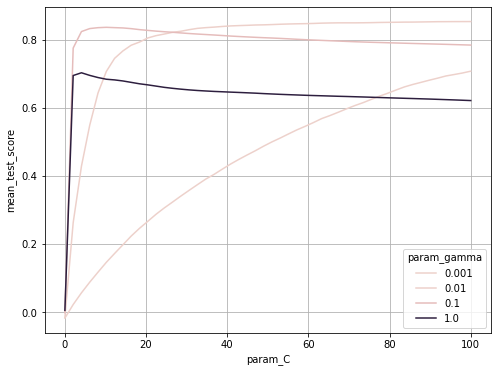

In [119]:
plt.figure(figsize = (8,6))
sns.lineplot(x = 'param_C', y = 'mean_test_score', data = tmp6, hue='param_gamma' )
plt.grid()
plt.show()